# 분 단위 암호화폐 가격의 급등/급락 신호(Signs of a soaring/plummeting in cryptocurrency prices in minutes)
- 암호화폐의 가격이 급등/급락하는 것은 암호화폐간의 상관관계 상승과 하락에 영향이 있는 것으로 보여 진행
- 암호화폐의 가격이 급등/급락하기 직전에 암호화폐간의 상관관계 변화를 통해 이를 감지

In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### 현재 바이낸스 거래소에서 거래되고 있는 암호화폐 ticker to USDT 리스트 반환하는 함수
def get_USDT_tickers():
    binance = ccxt.binance()
    markets = binance.fetch_markets()
    USDT_tickers = [market['symbol'] for market in markets if market['quote'] == 'USDT' and market['active']]
    
    return USDT_tickers

'''
### 하나의 데이터프레임에 암호화폐의 데이터를 모아놓는 함수
crypto_list: ticker to USDT 리스트
feature: open, high, low, close, volume 중 선택
timeframe: 측정할 시간단위 선택(1m, 5m, 1h, 1d, ...)
limit: 불러올 데이터의 크기
'''
def CryptoGenerator(crypto_list, feature, timeframe, limit):
    crypto_df = pd.DataFrame()
    
    for crypto in crypto_list:
        binance = ccxt.binance()
        ohlcv = binance.fetch_ohlcv(f"{crypto}", timeframe=timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
        df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
        df.set_index('datetime', inplace=True)
        df = pd.DataFrame(df[f'{feature}'])
        df.rename(columns={f'{feature}':f'{crypto}'}, inplace=True)
        
        crypto_df = pd.concat([crypto_df, df], axis=1)
        
    return crypto_df

### 암호화폐의 수익률 계산 함수
'''
data: ticker to USDT 리스트
'''
def ReturnGenerator(data):
    profit = pd.DataFrame()

    for column in data.columns:
        returns = data[column].pct_change()
        profit[column] = returns

    return profit[1:]

### 시간의 흐름에 따라 암호화폐간의 상관계수를 저장하여 상관계수 시계열을 생성하는 함수
'''
data: ticker to USDT 리스트
crypto_num: 상관관계를 볼 해당 암호화폐의 column 번호
window_size: window_size 기간의 암호화폐간의 상관계수 계산
method: pearson, spearman, kendall 중 선택
'''

def CorrFlowGenerator(data, crypto_num, window_size, method):
    correlation_data = pd.DataFrame(index=range(window_size, len(data)), columns=data.columns)

    # 시간축으로 윈도우 크기만큼 데이터를 분석하고 상관계수를 계산하여 저장
    for i in range(window_size, len(data)):
        window = data.iloc[i-window_size:i]
        correlations = window.corr(method=method)
        correlation_data.loc[i] = correlations.iloc[crypto_num, :]

    return correlation_data

In [3]:
tickers = get_USDT_tickers()
crypto = CryptoGenerator(tickers[:100], 'close', '1m', 1000) # tickers 리스트의 200개 암호화폐 데이터에 대해 진행
crypto.dropna(inplace=True)

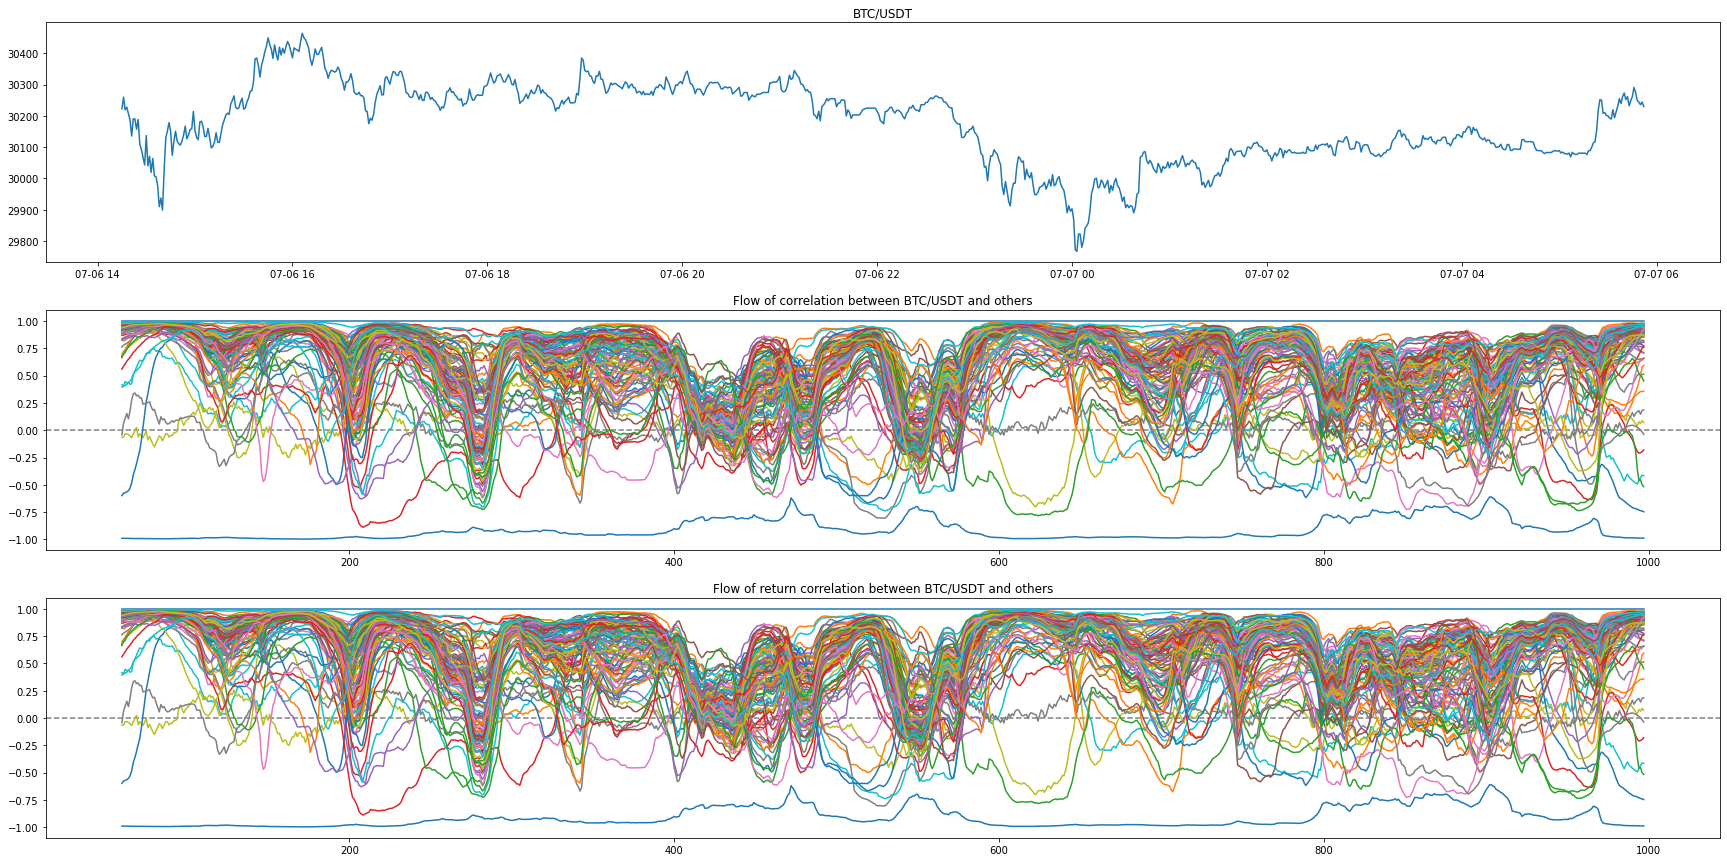

In [4]:
crypto_num = 0 # 암호화폐간의 상관관계를 볼 암호호폐의 column number
window_size = 60 # 상관관계를 파악할 기간
corr_method = 'pearson' # 'pearson', 'spearman', kendall'

# 암호화폐 종가의 상관관계 흐름 데이터
closecorr_flow = CorrFlowGenerator(crypto, crypto_num, window_size, 'pearson')

# 암호화폐 종가 수익률의 상관관계 흐름 데이터
returncorr_flow = CorrFlowGenerator(ReturnGenerator(crypto), crypto_num, window_size, 'pearson')

plt.figure(figsize=(30, 15))

plt.subplot(311)
plt.title(f'{crypto.columns[crypto_num]}')
plt.plot(crypto.iloc[:, crypto_num][window_size:])

plt.subplot(312)
plt.title(f'Flow of correlation between {crypto.columns[crypto_num]} and others')
plt.axhline(0, color='gray', linestyle='--')
plt.plot(closecorr_flow)

plt.subplot(313)
plt.title(f'Flow of return correlation between {crypto.columns[crypto_num]} and others')
plt.axhline(0, color='gray', linestyle='--')
plt.plot(closecorr_flow)

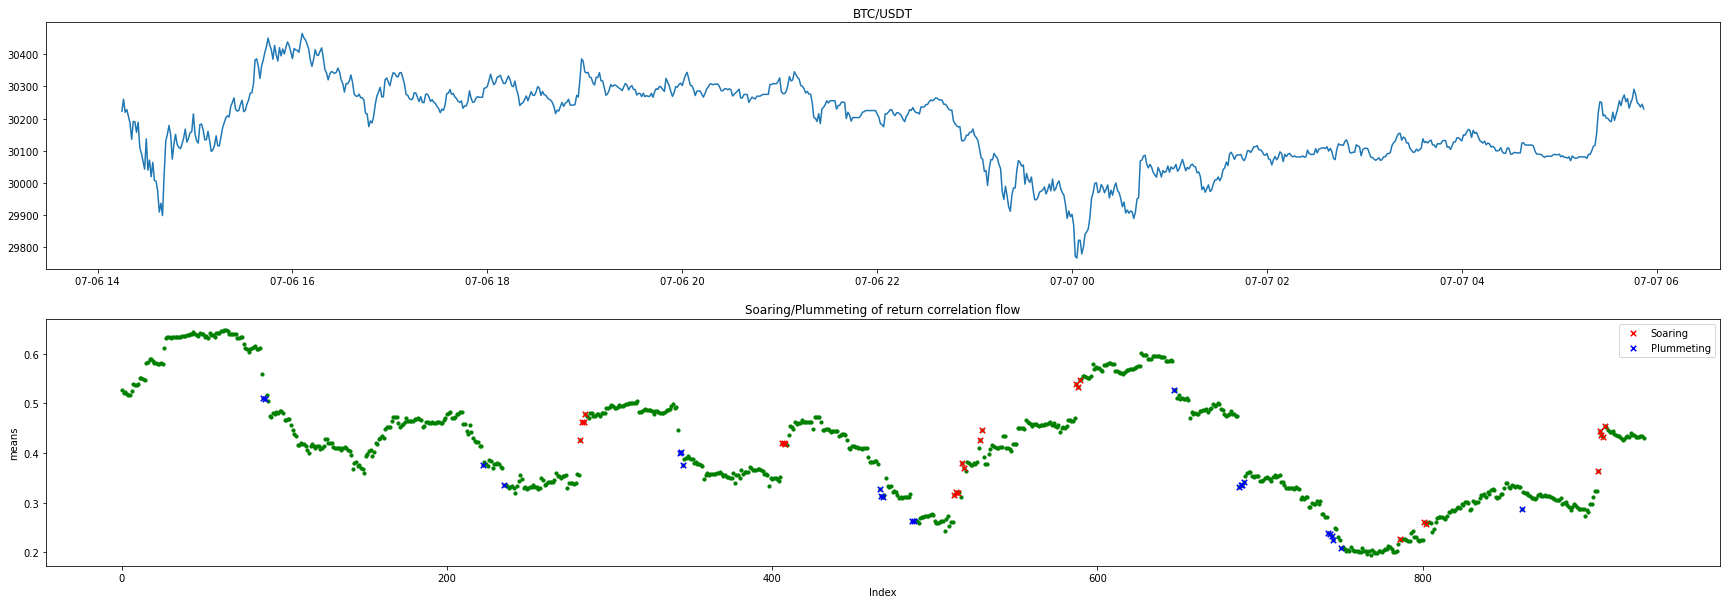

In [5]:
mean_returncorr = returncorr_flow.mean(axis=1)

df = pd.DataFrame(mean_returncorr)
df.columns = ['means']

# 이상 감지할 column 선택
column_name = 'means'
column_data = df[column_name]

# 지난 mean_window의 평균보다 x% 높거나 낮은 데이터를 표시하기 위함
x = 10 # 10%로 설정

# 평균 윈도우
mean_window = 5

# 상관관계 급등/급락 탐지
soaring_indices = []
plummeting_indices = []

for i in range(mean_window, len(column_data)):
    mean_window_mean = column_data.iloc[i - mean_window:i].mean()
    if column_data.iloc[i] > (mean_window_mean * (1 + x / 100)):
        soaring_indices.append(i)

    if column_data.iloc[i] < (mean_window_mean * (1 - x / 100)):
        plummeting_indices.append(i)

# 그래프로 시각화
plt.figure(figsize=(30, 10))
plt.subplot(211)
plt.title(f'{crypto.columns[crypto_num]}')
plt.plot(crypto.iloc[:, crypto_num][window_size:])


plt.subplot(212)
plt.scatter(range(len(column_data)), column_data, c='green', s=10, alpha=1)
plt.scatter(soaring_indices, column_data.iloc[soaring_indices], c='red', marker='x', s=30, label='Soaring')
plt.scatter(plummeting_indices, column_data.iloc[plummeting_indices], c='blue', marker='x', s=30, label='Plummeting')
plt.xlabel('Index')
plt.ylabel(column_name)
plt.title('Soaring/Plummeting of return correlation flow')
plt.legend()

plt.show()